# Generate scene and LSST deblend it

Use the Scene class to test out some configurations and try to figure out what's not working right with their deblender.

In [1]:
from __future__ import print_function, division
import glob
from astropy.io import fits
import astropy.modeling.models as models
import numpy as np
from scipy import stats
import astropy.stats
import astropy.table
from astropy import wcs
from astropy import convolution
import lupton_rgb
import img_scale

In [2]:
%matplotlib inline
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
plt.style.use('ggplot')
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['axes.grid'] = False

In [4]:
import os
from os.path import exists, isdir, basename, split

_pysynphot_ref_file_roots = (
    '/Users/hcferguson/data/cdbs',
    '/Users/jlong/cdbs',
    '/grp/hst/cdbs'
)
if not os.environ.get('PYSYN_CDBS', False):
    for location in _pysynphot_ref_file_roots:
        if isdir(location):
            os.environ['PYSYN_CDBS'] = location

assert os.environ.get('PYSYN_CDBS', False)
import pysynphot

In [5]:
from IPython.display import display

In [6]:
GALAXY_A_PATH = os.environ['PYSYN_CDBS'] + '/grid/bc95/templates/bc95_c_10E9.fits'
GALAXY_B_PATH = os.environ['PYSYN_CDBS'] + '/grid/bc95/templates/bc95_c_10E7.fits'
STAR_PATH = os.environ['PYSYN_CDBS'] + '/grid/pickles/dat_uvk/pickles_uk_9.fits'
SOLAR_PATH = os.environ['PYSYN_CDBS']  + '/calspec/sun_reference_001.fits'

LSST_FWHM_ARCSEC = 0.7
LSST_PIXEL_SCALE = 0.2
SDSS_BANDS = ('u', 'g', 'r', 'i', 'z')
DEFAULT_OVERSAMPLING = 2

In [12]:
from scenekit import Scene, ChromaticGaussianPSF

In [13]:
chromatic_psf = ChromaticGaussianPSF(
    fwhm_arcsec=0.7,
    reference_wavelength=pysynphot.ObsBandpass('sdss,i').avgwave()
)
psf_hdulist = chromatic_psf.fits_for_bands('ugriz', LSST_PIXEL_SCALE)

In [21]:
import lsst.afw.table
import lsst.afw.image
import lsst.afw.math
import lsst.meas.algorithms
import lsst.meas.base
import lsst.meas.deblender
from astropy.table import Table
import numpy

def deblend_run(image_array, variance_array, psf_array):
    schema = lsst.afw.table.SourceTable.makeMinimalSchema()
    detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema)
#     detect.config.doTempLocalBackground = True
    deblend = lsst.meas.deblender.SourceDeblendTask(schema=schema)
    measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)
    
    image_array = image_array.astype(np.float32).copy()
    image_array -= image_array[1:100,1:100].mean()

    image = lsst.afw.image.ImageF(image_array.astype(np.float32))
    variance = lsst.afw.image.ImageF(variance_array.astype(np.float32))
    masked_image = lsst.afw.image.MaskedImageF(image, None, variance)

    psf_image = lsst.afw.image.ImageD(psf_array.astype(np.float64))
    psf_kernel = lsst.afw.math.FixedKernel(psf_image)
    psf = lsst.meas.algorithms.KernelPsf(psf_kernel)

    exposure = lsst.afw.image.ExposureF(masked_image)
    exposure.setPsf(psf)

    table = lsst.afw.table.SourceTable.make(schema)  # this is really just a factory for records, not a table
    detect_result = detect.run(table, exposure)

    catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty

    deblend.run(exposure, catalog)

    measure.run(catalog, exposure)
    return catalog

def _deblend_scene(scene, band='u', cutoff_sigma=3):
    idx = scene.bands_to_indices[band]
    std = numpy.std(scene.canvas[idx][1:100,1:100])
    variance = std**2
#     variance = np.average(scene.canvas[idx][0:10,0:10])
    stack_catalog = deblend_run(
        image_array=scene.canvas[idx],
        variance_array=np.ones_like(scene.canvas[idx]) * variance,
        psf_array=psf_hdulist[band.upper()].data,
    )
    stack_catalog.writeFits('./temp.fits')
    catalog = Table.read('./temp.fits')
    mask = catalog['base_PsfFlux_flux'] > 3 * std
    faint = catalog[~mask]
    good_catalog = catalog[mask]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(scene.canvas[idx], norm=LogNorm())
    ax.scatter(good_catalog['base_GaussianCentroid_x'], good_catalog['base_GaussianCentroid_y'], color='blue')
    ax.scatter(faint['base_GaussianCentroid_x'], faint['base_GaussianCentroid_y'], color='red')
    ymax, xmax = scene.canvas[idx].shape
    ax.set_xlim(0, ymax-1)
    ax.set_ylim(0, xmax-1)
    display(fig)
    return catalog

In [22]:
def detect_run(image_array, variance_array, psf_array):
    schema = lsst.afw.table.SourceTable.makeMinimalSchema()
    detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema)
#     detect.config.doTempLocalBackground = True
#     deblend = lsst.meas.deblender.SourceDeblendTask(schema=schema)
    measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)
    
    image_array = image_array.astype(np.float32).copy()
    image_array -= image_array[1:100,1:100].mean()

    image = lsst.afw.image.ImageF(image_array.astype(np.float32))
    variance = lsst.afw.image.ImageF(variance_array.astype(np.float32))
    masked_image = lsst.afw.image.MaskedImageF(image, None, variance)

    psf_image = lsst.afw.image.ImageD(psf_array.astype(np.float64))
    psf_kernel = lsst.afw.math.FixedKernel(psf_image)
    psf = lsst.meas.algorithms.KernelPsf(psf_kernel)

    exposure = lsst.afw.image.ExposureF(masked_image)
    exposure.setPsf(psf)

    table = lsst.afw.table.SourceTable.make(schema)  # this is really just a factory for records, not a table
    detect_result = detect.run(table, exposure)

    catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty

#     deblend.run(exposure, catalog, exposure.getPsf())

    measure.run(catalog, exposure)
    return catalog

def _detect_scene(scene, band='u', cutoff_sigma=3):
    idx = scene.bands_to_indices[band]
    std = numpy.std(scene.canvas[idx][1:100,1:100])
    variance = std**2
#     variance = np.average(scene.canvas[idx][0:10,0:10])
    stack_catalog = detect_run(
        image_array=scene.canvas[idx],
        variance_array=np.ones_like(scene.canvas[idx]) * variance,
        psf_array=psf_hdulist[band.upper()].data,
    )
    stack_catalog.writeFits('./temp.fits')
    catalog = Table.read('./temp.fits')
    mask = catalog['base_PsfFlux_flux'] > 3 * std
    faint = catalog[~mask]
    good_catalog = catalog[mask]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(scene.canvas[idx], norm=LogNorm())
    ax.scatter(good_catalog['base_GaussianCentroid_x'], good_catalog['base_GaussianCentroid_y'], color='blue')
    ax.scatter(faint['base_GaussianCentroid_x'], faint['base_GaussianCentroid_y'], color='red')
    ymax, xmax = scene.canvas[idx].shape
    ax.set_xlim(0, ymax-1)
    ax.set_ylim(0, xmax-1)
    display(fig)
    return catalog

In [23]:
def _show(scene):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    for idx, band in enumerate(scene.bands):
        scene.display(band=band, ax=axes.flatten()[idx], norm=LogNorm())

    scene.display_rgb(ax=axes.flatten()[-1], norm=LogNorm())
    plt.tight_layout()

# Do one scene

In [24]:
# Parameters that might affect deblendability
BASE_MAG = 10
A_MAG = BASE_MAG
B_MAG = BASE_MAG
R_EFF = 25 * 0.2  # 25 px * 0.2 arcsec / px
THETA = 0
SEP = 24 # arcsec


ELLIPTICITY = 0.5
NPIX = 512
STAR_OFFSET = NPIX // 4 * 0.2

(/grp/hst/cdbs/comp/nonhst/sdss_u_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_g_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_r_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_i_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_z_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_u_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_g_005_syn.fits) does not have a defined binset in the wavecat 

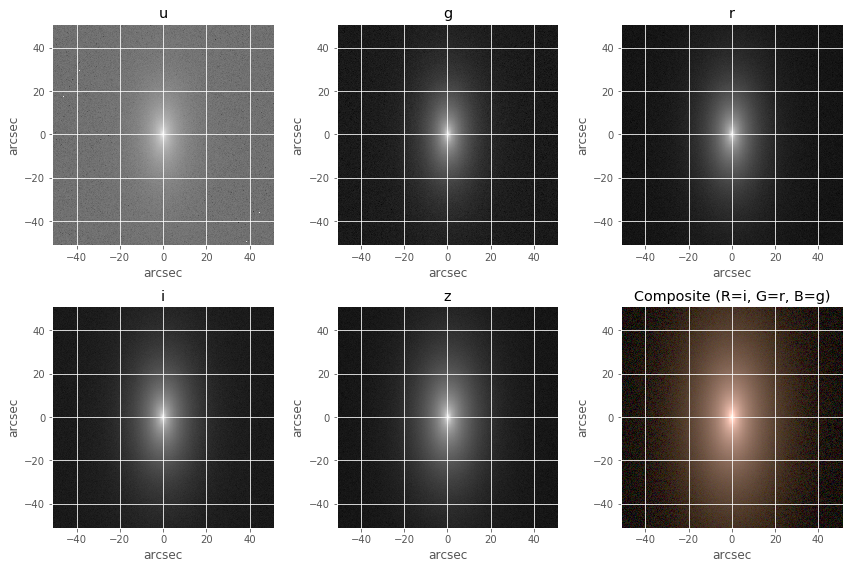

In [25]:
gal_scene = Scene(
    chromatic_psf=chromatic_psf, # kernel_fwhm_arcsec=0.7,
    width_px=NPIX,
    height_px=NPIX,
)
gal_scene.add_sersic_galaxy(
    spectrum=GALAXY_A_PATH,
    redshift=0.0,
    abmag=A_MAG,
    r_eff_arcsec=R_EFF,
    sersic_index=4.,
    x_arcsec=0,
    y_arcsec=0,
    ellipticity=ELLIPTICITY,
    theta=np.pi / 2,
)
# scene.add_sersic_galaxy(
#     spectrum=GALAXY_B_PATH,
#     redshift=0.0,
#     abmag=B_MAG,
#     r_eff_arcsec=R_EFF,
#     sersic_index=1.,
#     x_arcsec=SEP,
#     y_arcsec=0,
#     ellipticity=ELLIPTICITY,
#     theta=np.pi / 2 + THETA,
# )
# scene.add_star(
#     spectrum=STAR_PATH,
#     abmag=8,
#     x_arcsec=-STAR_OFFSET,
#     y_arcsec=-STAR_OFFSET,
# )
# _ = scene.render()
_show(gal_scene)

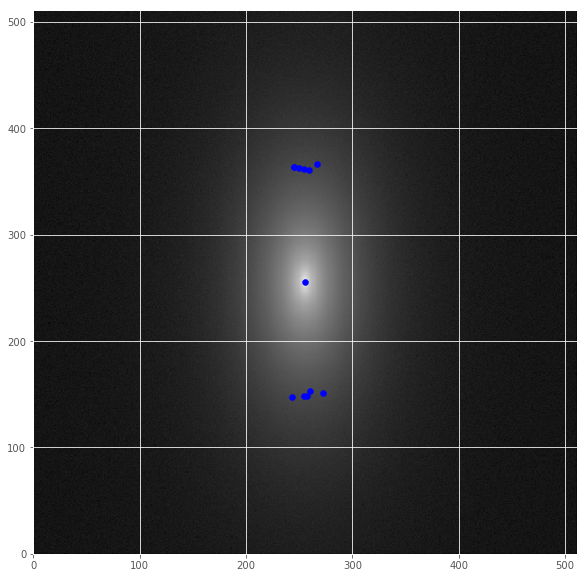

flags [70],id,coord_ra,coord_dec,parent,deblend_nChild,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psfFlux,base_GaussianCentroid_x,base_GaussianCentroid_y,base_NaiveCentroid_x,base_NaiveCentroid_y,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xSigma,base_SdssCentroid_ySigma,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxSigma,base_SdssShape_yySigma,base_SdssShape_xySigma,base_SdssShape_x,base_SdssShape_y,base_SdssShape_flux,base_SdssShape_fluxSigma,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_flux_xx_Cov,base_SdssShape_flux_yy_Cov,base_SdssShape_flux_xy_Cov,base_CircularApertureFlux_3_0_flux,base_CircularApertureFlux_3_0_fluxSigma,base_CircularApertureFlux_4_5_flux,base_CircularApertureFlux_4_5_fluxSigma,base_CircularApertureFlux_6_0_flux,base_CircularApertureFlux_6_0_fluxSigma,base_CircularApertureFlux_9_0_flux,base_CircularApertureFlux_9_0_fluxSigma,base_CircularApertureFlux_12_0_flux,base_CircularApertureFlux_12_0_fluxSigma,base_CircularApertureFlux_17_0_flux,base_CircularApertureFlux_17_0_fluxSigma,base_CircularApertureFlux_25_0_flux,base_CircularApertureFlux_25_0_fluxSigma,base_CircularApertureFlux_35_0_flux,base_CircularApertureFlux_35_0_fluxSigma,base_CircularApertureFlux_50_0_flux,base_CircularApertureFlux_50_0_fluxSigma,base_CircularApertureFlux_70_0_flux,base_CircularApertureFlux_70_0_fluxSigma,base_GaussianFlux_flux,base_GaussianFlux_fluxSigma,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_Variance_value,footprint
,,rad,rad,,,pix,pix,,pix,pix,pix,pix,pix,pix,pix,pix,pix2,pix2,pix2,pix2,pix2,pix2,pix,pix,ct,ct,pix2,pix2,pix2,ct pix2,ct pix2,ct pix2,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,,
bool,int64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
False .. False,1,nan,nan,0,0,nan,nan,nan,243.0,147.0,243.010390815,147.02602432,243.0,147.0,nan,nan,352.514091355,533.235344226,77.6576347704,nan,nan,nan,240.652757911,149.109136833,nan,nan,1.50251040581,1.50251040581,0.0,nan,nan,nan,9205.30859375,43.9279823303,20282.0683594,66.5365829468,33209.4453125,89.2109680176,66417.84375,134.502914429,109172.905208,178.882067463,217938.866035,255.687741142,494568.960602,377.212701419,1092288.04813,528.745903234,2061520.36904,754.473490634,3266426.89565,1056.15296971,1476167.41494,623.642698341,6250.46671082,37.0144818884,nan,1
False .. False,2,nan,nan,0,3,nan,nan,nan,257.0,148.0,257.00988512,148.018005063,257.0,148.0,nan,nan,472.210032892,645.667616568,-11.1274814332,nan,nan,nan,256.019247935,151.836048791,nan,nan,1.50251040581,1.50251040581,0.0,nan,nan,nan,10412.4550781,43.9279823303,23276.6054688,66.5365829468,40947.9648438,89.2109680176,91872.578125,134.502914429,156397.245114,178.882067463,308743.67316,255.687741142,687918.728029,377.212701419,1373245.54614,528.745903234,2313282.63608,754.473490634,3555726.73587,1056.15296971,2198702.52749,709.486921737,7063.66309182,37.0144818884,nan,2
False .. True,3,nan,nan,0,0,nan,nan,nan,255.500764016,255.500244513,255.194096723,255.107068237,255.501018202,255.500889747,1.39033e-05,2.56083e-05,4.16264915521,14.0071220943,-0.000536615677586,3.62719e-05,4.70484e-05,0.000122053,255.500907399,255.500832636,27084842.4242,118.004105442,1.50251040581,1.50251040581,0.0,-0.00214012,2.75887e-07,-0.0072014,12065368.0,44.3745536804,17677942.0,66.3871307373,22877536.0,89.0350341797,31635320.0,134.333206177,38644306.0215,180.296176958,48136475.687,257.243808149,58846364.9617,378.652632986,67780327.7511,528.677283948,76291583.8631,755.194440145,82710599.5828,1056.39339869,27084842.4242,83.4415039204,1036775

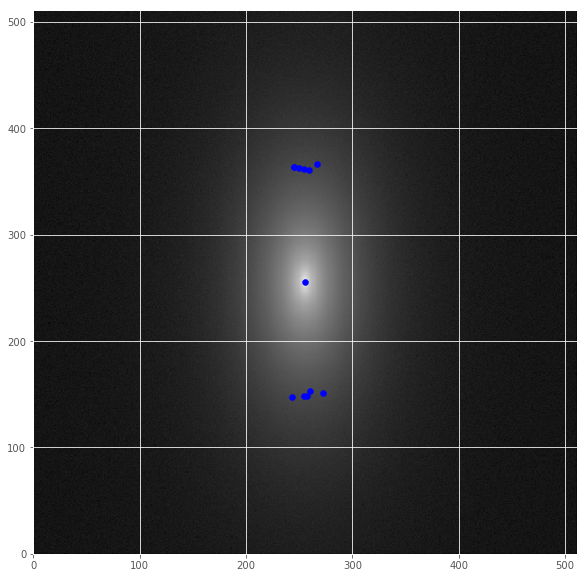

In [26]:
catalog = _deblend_scene(gal_scene, band='r', cutoff_sigma=6)
catalog

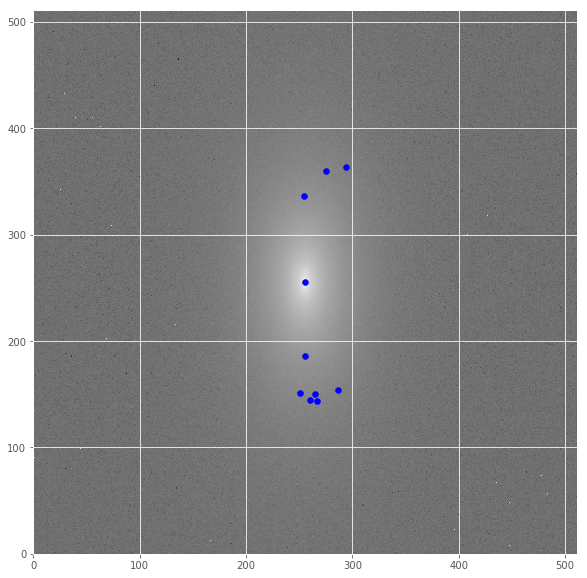

flags [62],id,coord_ra,coord_dec,parent,base_GaussianCentroid_x,base_GaussianCentroid_y,base_NaiveCentroid_x,base_NaiveCentroid_y,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xSigma,base_SdssCentroid_ySigma,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxSigma,base_SdssShape_yySigma,base_SdssShape_xySigma,base_SdssShape_x,base_SdssShape_y,base_SdssShape_flux,base_SdssShape_fluxSigma,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_flux_xx_Cov,base_SdssShape_flux_yy_Cov,base_SdssShape_flux_xy_Cov,base_CircularApertureFlux_3_0_flux,base_CircularApertureFlux_3_0_fluxSigma,base_CircularApertureFlux_4_5_flux,base_CircularApertureFlux_4_5_fluxSigma,base_CircularApertureFlux_6_0_flux,base_CircularApertureFlux_6_0_fluxSigma,base_CircularApertureFlux_9_0_flux,base_CircularApertureFlux_9_0_fluxSigma,base_CircularApertureFlux_12_0_flux,base_CircularApertureFlux_12_0_fluxSigma,base_CircularApertureFlux_17_0_flux,base_CircularApertureFlux_17_0_fluxSigma,base_CircularApertureFlux_25_0_flux,base_CircularApertureFlux_25_0_fluxSigma,base_CircularApertureFlux_35_0_flux,base_CircularApertureFlux_35_0_fluxSigma,base_CircularApertureFlux_50_0_flux,base_CircularApertureFlux_50_0_fluxSigma,base_CircularApertureFlux_70_0_flux,base_CircularApertureFlux_70_0_fluxSigma,base_GaussianFlux_flux,base_GaussianFlux_fluxSigma,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_Variance_value,footprint
,,rad,rad,,pix,pix,pix,pix,pix,pix,pix,pix,pix2,pix2,pix2,pix2,pix2,pix2,pix,pix,ct,ct,pix2,pix2,pix2,ct pix2,ct pix2,ct pix2,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,,
bool,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
False .. False,1,nan,nan,0,267.0,144.0,266.91068028,144.046672843,267.0,144.0,nan,nan,594.705940248,1120.66885154,-234.316752252,nan,nan,nan,266.009404888,150.426046545,nan,nan,0.347631235577,0.347631235577,0.0,nan,nan,nan,539.292175293,18.6346893311,1177.06677246,28.2254981995,2004.66674805,37.8442001343,4534.25097656,57.0575408936,7860.11466715,75.8835757907,16171.6693451,108.465316613,35927.7232316,160.01742949,73345.3339379,224.299340851,149019.106227,320.055258309,226878.200641,448.030733656,198064.014832,358.215123701,160.789800995,8.91359048773,nan,1
False .. False,2,nan,nan,0,260.0,145.0,260.041525578,144.920125692,260.0,145.0,nan,nan,705.038368074,1834.45875675,-160.910095679,nan,nan,nan,261.69817552,155.486841739,nan,nan,0.347631235577,0.347631235577,0.0,nan,nan,nan,630.874694824,18.6346893311,1393.34802246,28.2254981995,2376.12548828,37.8442001343,5070.51513672,57.0575408936,8778.18125531,75.8835757907,18370.0596113,108.465316613,40523.7501306,160.01742949,81280.5245097,224.299340851,157697.043408,320.055258309,237830.480864,448.030733656,308514.51046,429.801569291,171.154894595,8.91359048773,nan,2
False .. False,3,nan,nan,0,265.0,150.0,265.014220802,149.975094702,265.0,150.0,nan,nan,783.931342963,1688.54039419,-290.576953718,nan,nan,nan,265.743946492,159.346905698,nan,nan,0.347631235577,0.347631235577,0.0,nan,nan,nan,801.419616699,18.6346893311,1736.29638672,28.2254981995,2830.41674805,37.8442001343,6133.75146484,57.0575408936,10628.5482125,75.8835757907,21637.5076687,108.465316613,47787.062389,160.01742949,96644.6821085,224.299340851,170798.331763,320.055258309,267876.051334,448.030733656,328438.557914,427.390093096,208.223583767,8.91359048773,nan,3
False .. False,4,nan,nan,0,251.0,151.0,250.914828202,150.900722118,251.0,151.0,nan,nan,1520.41985832,9976.73782301,420.316101106,nan,nan,nan,263.384426278,183.046413978,nan,nan,0.347631235577,0.347631235577,0.0,nan,nan,nan,79

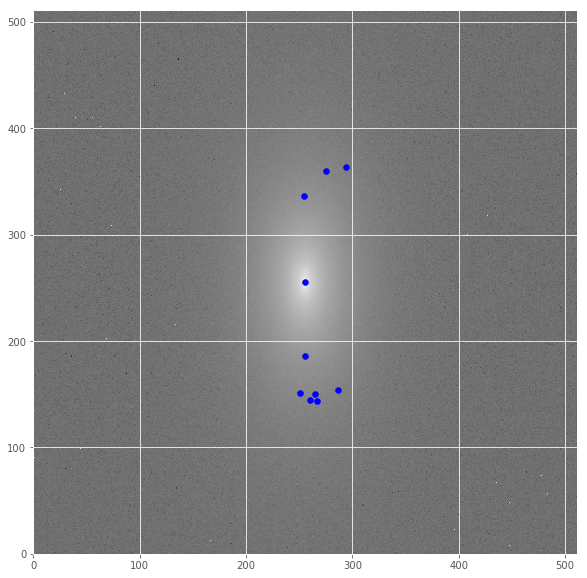

In [27]:
_detect_scene(gal_scene)

In [ ]:
_deblend_scene(gal_scene)

In [ ]:
plt.imshow(gal_scene.canvas[2])

In [ ]:
scene = Scene(
    chromatic_psf=chromatic_psf, # kernel_fwhm_arcsec=0.7,
    width_px=NPIX,
    height_px=NPIX,
)
scene.add_star(
    spectrum=STAR_PATH,
    abmag=8,
    x_arcsec=-STAR_OFFSET,
    y_arcsec=-STAR_OFFSET,
)

scene.add_star(
    spectrum=STAR_PATH,
    abmag=8,
    x_arcsec=STAR_OFFSET,
    y_arcsec=STAR_OFFSET,
)


_show(scene)
catalog = _deblend_scene(scene, band='r')
catalog